# Mushroom Body Demo
In this notebook, we go through the following examples.

1. Simulate Larva Mushroom Body
2. Change PN to KC connectivity by reducing the number of PN connected to a given KC to 2
3. Change strength of APL inhibition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import typing as tp
import numpy as np
from itertools import product
from eoscircuits import mb
import olftrans as olf
import olftrans.data
import olftrans.fbl
from olftrans.plot import plot_mat
from neurokernel.LPU.InputProcessors.StepInputProcessor import StepInputProcessor
import matplotlib.pyplot as plt
import typing as tp
import pandas as pd
import seaborn as sns
from eoscircuits.plot import plot_data, plot_spikes

/mnt/server-home/tingkai/Project/FBL/olftrans/olftrans/olftrans.py:210: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))
/mnt/server-home/tingkai/Project/FBL/olftrans/olftrans/olftrans.py:210: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))


## Setup

In [3]:
receptor_names = olf.fbl.LARVA.affinities.loc['ethyl acetate'].index.values.astype(str)
affinities = olf.fbl.LARVA.affinities.loc['ethyl acetate'].values

dt = 1e-5
dur = 4
steps = int((dur+dt/2)//dt)
t = np.arange(steps)*dt

# 1. Simulate Larva Mushroom Body

In [4]:
cfg = mb.MBConfig(
    affs=affinities,
    receptors=receptor_names,
    NP=1, NO=1, NPreLN=1, NPosteLN=1, NPostiLN=2, 
    NK=200, NAPL=1,
    node_params=dict(
        osn_bsgs=dict(sigma=0.),
        osn_axts=dict(gamma=1.),
        postelns=dict(a2=0.012),
        apls=dict(N=200.),
        kcs=dict(threshold=0.6)
    )
)
mb_circ = mb.MBCircuit.create_from_config(cfg)

In [5]:
fi = StepInputProcessor('conc', mb_circ.inputs['conc'], 100., start=1, stop=3)
fi, fo, lpu = mb_circ.simulate(
    t, fi, 
    record_var_list=[
        (
            'I', 
            sum(mb_circ.config.osn_otps,[]) + \
            mb_circ.config.kcdends
        ),
        (
            'r', 
            sum(mb_circ.config.pns,[]) + \
            mb_circ.config.kcs
        ),
        (
            'g', 
            sum(mb_circ.config.osn_alphas,[]) + \
            mb_circ.config.apls
        ),
        (
            'spike_state',
            sum(mb_circ.config.osn_bsgs, [])
        )
    ])

EOS: Number of OSNAxt2: 11
EOS: Number of KC: 200
EOS: Number of Alpha: 11
EOS: Number of KCDend: 200
EOS: Number of APL: 1
EOS: Number of NoisyConnorStevens: 11
EOS: Number of PN: 11
EOS: Number of PostLN: 33
EOS: Number of OTP: 11
EOS: Number of PreLN: 1
EOS: Number of Input: {'conc': 11}


EOS:   0%|          | 386/400000 [00:00<03:24, 1950.21it/s]

Compilation of executable circuit completed in 1.010559320449829 seconds


EOS: 100%|██████████| 400000/400000 [02:16<00:00, 2927.29it/s]


In [6]:
otp_I = fo.get_output(var='I', uids=sum(mb_circ.config.osn_otps,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(mb_circ.config.osn_bsgs,[]))
pn_r = fo.get_output(var='r', uids=sum(mb_circ.config.pns, []))
kc_r = fo.get_output(var='r', uids=mb_circ.config.kcs)
kcdend_I = fo.get_output(var='I', uids=mb_circ.config.kcdends)
apl_g = fo.get_output(var='g', uids=mb_circ.config.apls)

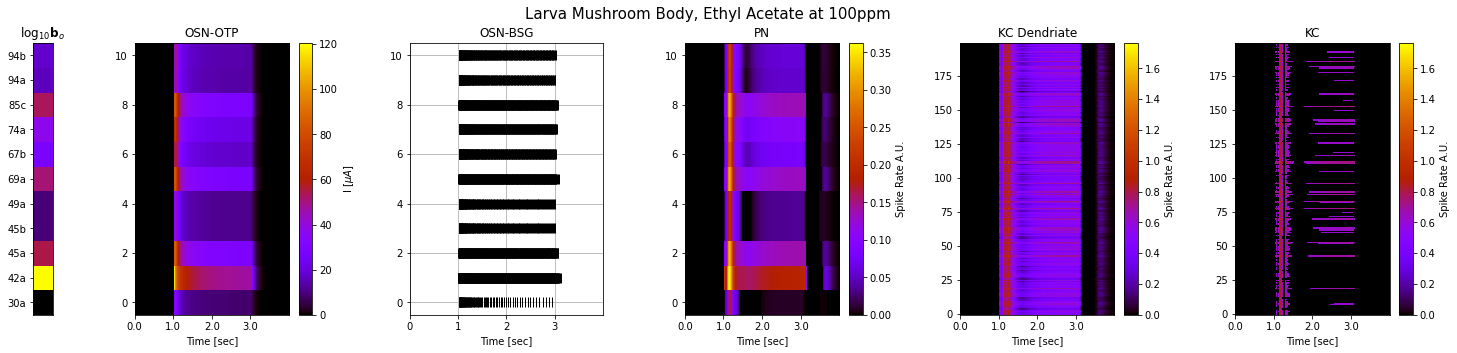

In [7]:
%matplotlib inline
fig,axes = plt.subplots(1,6, figsize=(25,5), gridspec_kw={'width_ratios': [1]+[10]*5, 'wspace':.5})
axes[0].imshow(np.log10(mb_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=10, color='k')
_ = plot_data(pn_r, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})
_ = plot_data(kcdend_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})
_ = plot_data(kc_r, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')
axes[0].set_xticks([])
axes[0].set_title('$\log_{10}\mathbf{b}_o$')
axes[0].set_yticks(np.arange(mb_circ.config.NR))
axes[0].set_yticklabels(mb_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('PN')
axes[4].set_title('KC Dendriate')
axes[5].set_title('KC')
axes[2].grid()
fig.suptitle('Larva Mushroom Body, Ethyl Acetate at 100ppm', fontsize=15)
plt.show()

# 2. Change PN to KC Routing - Change to connect 2 PNs to each KC

In [31]:
mb_circ.change_pn_to_kc(fanin=2)

In [32]:
fi = StepInputProcessor('conc', mb_circ.inputs['conc'], 100., start=1, stop=3)
fi, fo, lpu = mb_circ.simulate(
    t, fi, 
    record_var_list=[
        (
            'I', 
            sum(mb_circ.config.osn_otps,[]) + \
            mb_circ.config.kcdends
        ),
        (
            'r', 
            sum(mb_circ.config.pns,[]) + \
            mb_circ.config.kcs
        ),
        (
            'g', 
            sum(mb_circ.config.osn_alphas,[]) + \
            mb_circ.config.apls
        ),
        (
            'spike_state',
            sum(mb_circ.config.osn_bsgs, [])
        )
    ])

EOS: Number of OSNAxt2: 11
EOS: Number of KC: 200
EOS: Number of Alpha: 11
EOS: Number of KCDend: 200
EOS: Number of APL: 1
EOS: Number of NoisyConnorStevens: 11
EOS: Number of PN: 11
EOS: Number of PostLN: 33
EOS: Number of OTP: 11
EOS: Number of PreLN: 1
EOS: Number of Input: {'conc': 11}


EOS:   0%|          | 388/400000 [00:00<03:24, 1956.72it/s]

Compilation of executable circuit completed in 1.472670316696167 seconds


EOS: 100%|██████████| 400000/400000 [02:22<00:00, 2805.86it/s]


In [33]:
otp_I = fo.get_output(var='I', uids=sum(mb_circ.config.osn_otps,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(mb_circ.config.osn_bsgs,[]))
pn_r = fo.get_output(var='r', uids=sum(mb_circ.config.pns, []))
kc_r = fo.get_output(var='r', uids=mb_circ.config.kcs)
kcdend_I = fo.get_output(var='I', uids=mb_circ.config.kcdends)
apl_g = fo.get_output(var='g', uids=mb_circ.config.apls)

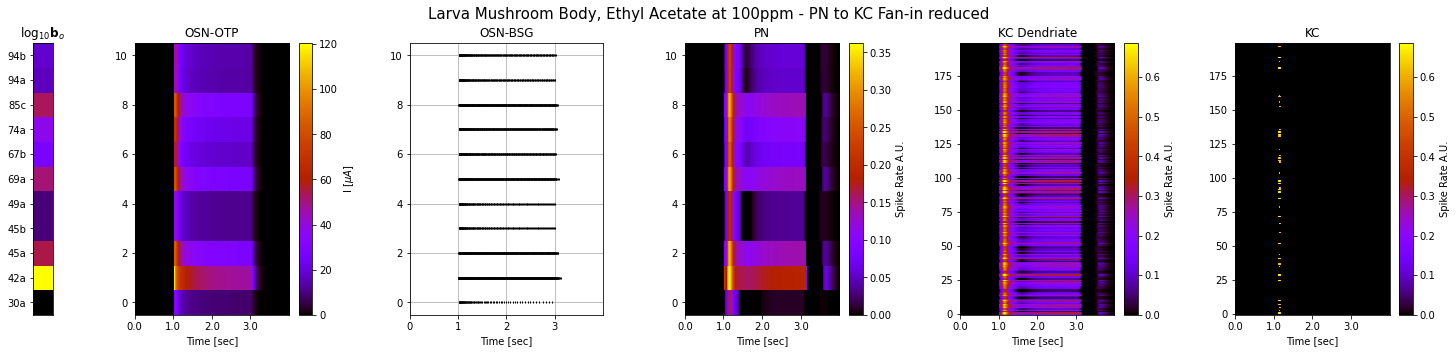

In [35]:
%matplotlib inline
fig,axes = plt.subplots(1,6, figsize=(25,5), gridspec_kw={'width_ratios': [1]+[10]*5, 'wspace':.5})
axes[0].imshow(np.log10(mb_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')
_ = plot_data(pn_r, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})
_ = plot_data(kcdend_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})
_ = plot_data(kc_r, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')
axes[0].set_xticks([])
axes[0].set_title('$\log_{10}\mathbf{b}_o$')
axes[0].set_yticks(np.arange(mb_circ.config.NR))
axes[0].set_yticklabels(mb_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('PN')
axes[4].set_title('KC Dendriate')
axes[5].set_title('KC')
axes[2].grid()
fig.suptitle('Larva Mushroom Body, Ethyl Acetate at 100ppm - PN to KC Fan-in reduced', fontsize=15)
plt.show()

# 3. Change APL to KC Strength - Decrease Inhibition Strength by Twice

In [36]:
mb_circ.change_pn_to_kc(fanin=6)
mb_circ.change_apl_strength(N=1000.)

In [40]:
fi = StepInputProcessor('conc', mb_circ.inputs['conc'], 100., start=1, stop=3)
fi, fo, lpu = mb_circ.simulate(
    t, fi, 
    record_var_list=[
        (
            'I', 
            sum(mb_circ.config.osn_otps,[]) + \
            mb_circ.config.kcdends
        ),
        (
            'r', 
            sum(mb_circ.config.pns,[]) + \
            mb_circ.config.kcs
        ),
        (
            'g', 
            sum(mb_circ.config.osn_alphas,[]) + \
            mb_circ.config.apls
        ),
        (
            'spike_state',
            sum(mb_circ.config.osn_bsgs, [])
        )
    ])

EOS: Number of OSNAxt2: 11
EOS: Number of KC: 200
EOS: Number of Alpha: 11
EOS: Number of KCDend: 200
EOS: Number of APL: 1
EOS: Number of NoisyConnorStevens: 11
EOS: Number of PN: 11
EOS: Number of PostLN: 33
EOS: Number of OTP: 11
EOS: Number of PreLN: 1
EOS: Number of Input: {'conc': 11}


EOS:   0%|          | 191/400000 [00:00<03:30, 1902.64it/s]

Compilation of executable circuit completed in 1.5733823776245117 seconds


EOS: 100%|██████████| 400000/400000 [02:15<00:00, 2948.48it/s]


In [41]:
otp_I = fo.get_output(var='I', uids=sum(mb_circ.config.osn_otps,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(mb_circ.config.osn_bsgs,[]))
pn_r = fo.get_output(var='r', uids=sum(mb_circ.config.pns, []))
kc_r = fo.get_output(var='r', uids=mb_circ.config.kcs)
kcdend_I = fo.get_output(var='I', uids=mb_circ.config.kcdends)
apl_g = fo.get_output(var='g', uids=mb_circ.config.apls)

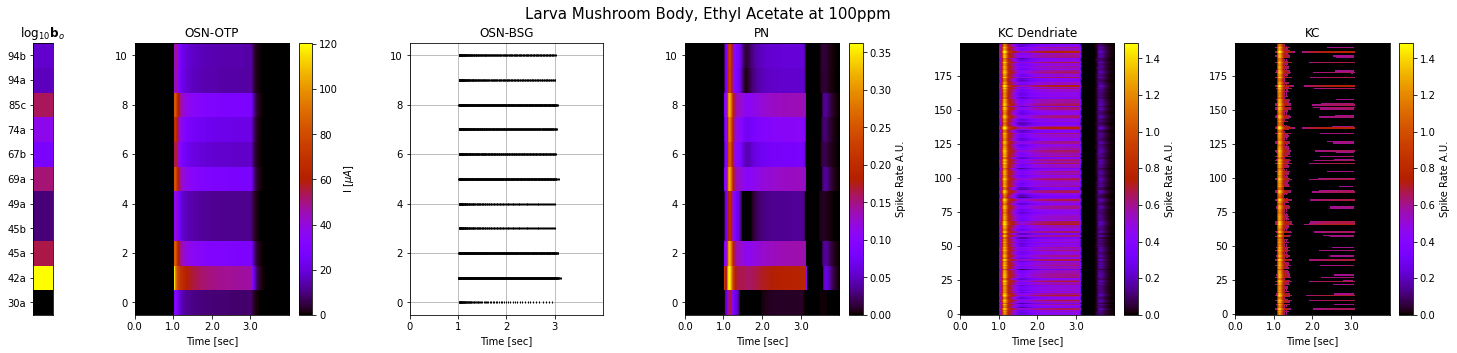

In [42]:
%matplotlib inline
fig,axes = plt.subplots(1,6, figsize=(25,5), gridspec_kw={'width_ratios': [1]+[10]*5, 'wspace':.5})
axes[0].imshow(np.log10(mb_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')
_ = plot_data(pn_r, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})
_ = plot_data(kcdend_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})
_ = plot_data(kc_r, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')
axes[0].set_xticks([])
axes[0].set_title('$\log_{10}\mathbf{b}_o$')
axes[0].set_yticks(np.arange(mb_circ.config.NR))
axes[0].set_yticklabels(mb_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('PN')
axes[4].set_title('KC Dendriate')
axes[5].set_title('KC')
axes[2].grid()
fig.suptitle('Larva Mushroom Body, Ethyl Acetate at 100ppm - Reduce APL Inhibition', fontsize=15)
plt.show()